# исследование применения методов машинного обучения в астрономии и построение расширенной диаграммы Герцшпрунга-Рассела
проект выполнен ученицей 8 класса Чумасовой Полиной

для решения астрономических задач всегда необходимы данные, иногда может возникать ситуация, при которой нет необходимого количества данных, за этим следует то, что задача начинает быть нерешаемой, но с помощью методов машинного обучения, которые я применила в этой тетрадке, количество аналогичных ситуаций можно свести к минимуму. 
  Я решила, что идеальным решением этой проблемы было бы построение диаграммы, в которой есть все параметры, которые могут понадобиться, как фундамент для нее я взяла диаграмму Герцшпрунга-Рассела, в которой можно наблюдать такие параметры как абсолютная звездная величина, светимость, температура, радиус, возраст и т.д, при анализе этой диаграммы я поняла, что в ней не хватает параметра расстояния

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn.datasets import make_regression
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KDTree
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error


import warnings
warnings.filterwarnings("ignore")

In [2]:
stefconst = 5.67 * 10**-8
pi = 3.14
Rro = 2.26*10**-8

в открытом источнике я нашла два набора данных, в одном были такие параметры как температура, освещенность, радиус, АЗВ, класс и цвет звезды, а в другом видимая звездная величина, параллакс, класс и АЗВ.
Загрузим их и предобработаем

<Axes: >

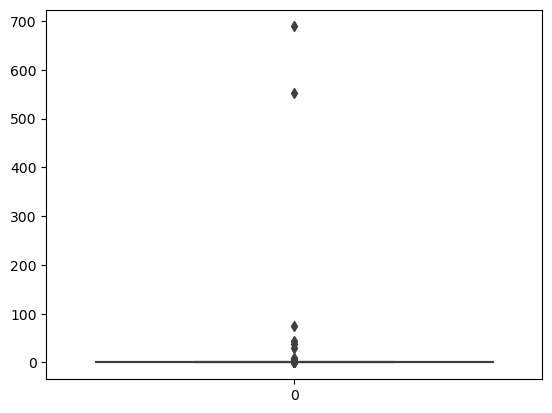

In [3]:
df = pd.read_csv(r"6 class csv.csv")
test1df = pd.read_csv(r"6 class csv.csv")
df2 = pd.read_csv(r"paralaxo.csv")

df.drop(["Star color", "Spectral Class"], axis=1, inplace=True)
df2.drop(['SpType'],axis = 1, inplace=True)

df = df[df['Absolute magnitude(Mv)'] > 0]
sns.boxplot(df['Luminosity(L/Lo)'])

так как у нас 2 набора данных с одной и той же переменной (АЗВ), мы можем выдвинуть гипотезу, что если соединить в пары максимально схожие значения АЗВ из двух столбцов, то и другие значения будут похожи, и если это так, то соединить наши датасеты, первой идеей как это сделать была более "ручная" версия :

In [4]:
tree = KDTree(df["Absolute magnitude(Mv)"].values.reshape((-1, 1)), leaf_size=3)
dist, ind = tree.query(df2["Amag"].values.reshape((-1, 1)), k=3)
mean_features = [df.iloc[idxes].mean(axis=0) for idxes in ind]
mean_features
df = pd.DataFrame(mean_features)
df.drop(['Star type'], axis = 1,inplace = True)
dfm  = pd.concat([df2,df],axis = 1)

In [5]:
m = np.array(dfm['Vmag'])
M = np.array(dfm['Amag'])
r = np.array(dfm['Radius(R/Ro)'])
t = np.array(dfm['Temperature (K)'])

distance1 = 10 * 10**((m - M)/5)
distance1

F = 10**(-0.4*(m-M))
distance2 = ((r**2 * stefconst * t**4)/F)**0.5
distance1 = Rro * distance1
dfm["dist1"] = distance1
dfm["dist2"] = distance2
dfm

,Vmag,Plx,e_Plx,B-V,Amag,TargetClass,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),dist1,dist2
0,6.901420,24.569658,0.862829,0.737416,20.449126,1,2896.000000,0.000536,0.103533,20.006667,4.411305e-10,0.403578
1,4.334196,2.198947,0.593309,1.153210,13.043324,0,6683.000000,0.004227,0.196307,13.053333,4.095273e-09,37.830661
2,7.873019,11.750465,0.616568,0.589166,17.736492,1,3012.333333,0.000465,0.118333,17.486667,2.406655e-09,2.722765
3,8.110014,2.143815,0.848508,1.322107,15.592469,0,2917.000000,0.000940,0.131333,16.086667,7.204725e-09,8.482978
4,8.025193,4.165622,0.899296,1.141646,16.379680,0,3227.000000,0.002512,0.092367,16.343333,4.821819e-09,4.886605
...,...,...,...,...,...,...,...,...,...,...,...,...
31636,7.561113,0.692340,0.843319,0.252874,12.542120,0,10837.666667,0.002177,0.115000,12.490000,2.279854e-08,324.458854
31637,8.078011,3.002784,0.689891,0.971966,15.379710,0,6714.333333,0.000557,0.117857,14.873333,7.830125e-09,43.834061
31638,7.065964,7.820498,0.885794,0.435381,16.737442,1,3048.333333,0.000314,0.116567,16.676667,2.629136e-09,3.000512
31639,8.685452,2.643033,1.064647,0.988600,14.859882,0,6482.000000,0.000740,0.059190,14.823333,1.315899e-08,34.480375


<Axes: xlabel='Luminosity(L/Lo)', ylabel='Count'>

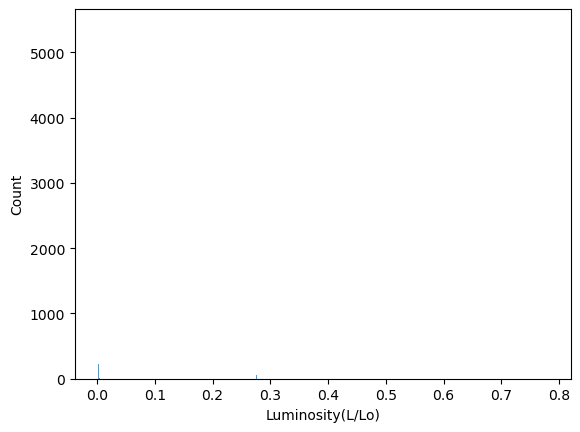

In [168]:
dfm['Luminosity(L/Lo)'].mean()
sns.histplot(dfm['Luminosity(L/Lo)'])

<Axes: >

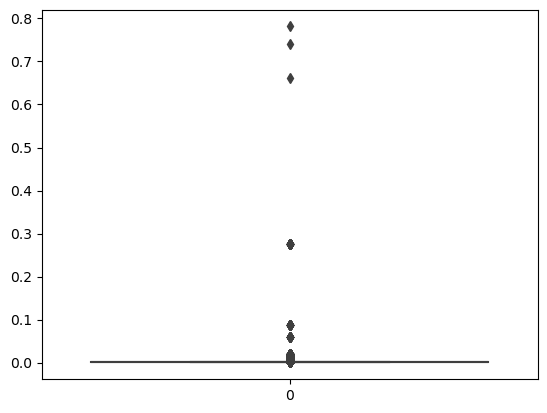

In [169]:
sns.boxplot(dfm['Luminosity(L/Lo)'])

In [170]:
corr = abs(dfm.corr())
corr.style.background_gradient(cmap='coolwarm')

,Vmag,Plx,e_Plx,B-V,Amag,TargetClass,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),dist1,dist2
Vmag,1.000000,0.191414,0.557063,0.046950,0.287126,0.128945,0.196061,0.026745,0.112961,0.284049,0.128052,0.045755
Plx,0.191414,1.000000,0.062239,0.074046,0.635550,0.348977,0.354138,0.085998,0.225950,0.604719,0.263955,0.156909
e_Plx,0.557063,0.062239,1.000000,0.053166,0.260421,0.102710,0.150619,0.020523,0.091803,0.248797,0.055983,0.018725
B-V,0.046950,0.074046,0.053166,1.000000,0.073903,0.554469,0.078831,0.010179,0.043722,0.089820,0.052674,0.036435
Amag,0.287126,0.635550,0.260421,0.073903,1.000000,0.442479,0.664059,0.271669,0.433444,0.985104,0.523672,0.412249
TargetClass,0.128945,0.348977,0.102710,0.554469,0.442479,1.000000,0.280207,0.067565,0.184470,0.444541,0.154972,0.106062
Temperature (K),0.196061,0.354138,0.150619,0.078831,0.664059,0.280207,1.000000,0.059151,0.014395,0.696837,0.330377,0.307071
Luminosity(L/Lo),0.026745,0.085998,0.020523,0.010179,0.271669,0.067565,0.059151,1.000000,0.418548,0.302322,0.679467,0.621961
Radius(R/Ro),0.112961,0.225950,0.091803,0.043722,0.433444,0.184470,0.014395,0.418548,1.000000,0.448377,0.415716,0.343176
Absolute magnitude(Mv),0.284049,0.604719,0.248797,0.089820,0.985104,0.444541,0.696837,0.302322,0.448377,1.000000,0.540248,0.419883


In [171]:
dfm = dfm.drop(['Absolute magnitude(Mv)'], axis = 1)

### 1.градиентный

In [172]:
y_co = ["Luminosity(L/Lo)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_co, axis=1), dfm[y_co], test_size=0.2, random_state=42)

est = GradientBoostingRegressor(n_estimators=100, learning_rate=1.3, max_depth=1,
                                random_state=0, loss='squared_error').fit(X_train, y_train)

Luminosity_gradient =  [est.predict(X_test), est.score(X_test, y_test).round(3)]
Luminosity_gradient_MAPE = (mean_absolute_percentage_error(y_test, est.predict(X_test))*100).round(2)

print("точность алгоритма для значений светимости:",Luminosity_gradient[1])
print("MAPE светимости:", Luminosity_gradient_MAPE, "%")

y_cols = ["Temperature (K)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_cols, axis=1), dfm[y_cols], test_size=0.2)
est.fit(X_train, y_train)

temperature_gradient = [est.predict(X_test), est.score(X_test, y_test).round(3)]
temperature_gradient_MAPE = (mean_absolute_percentage_error(y_test, est.predict(X_test))*100).round(2)

print("точность алгоритма для значений температуры:",temperature_gradient[1])
print("MAPE температуры:",temperature_gradient_MAPE, "%")


y_c = ['dist2']
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_c, axis=1), dfm[y_c], test_size=0.2,random_state=42)
est.fit(X_train, y_train)

distance_Gradient =  [est.predict(X_test), est.score(X_test, y_test).round(3)]
distance_gradient_MAPE = (mean_absolute_percentage_error(y_test, est.predict(X_test))*100).round(2)

print("точность алгоритма для значений расстояния:",distance_Gradient[1])
print("MAPE расстояния:",distance_gradient_MAPE, "%")

точность алгоритма для значений светимости: 0.999
MAPE светимости: 18.62 %
точность алгоритма для значений температуры: 0.983
MAPE температуры: 3.4 %
точность алгоритма для значений расстояния: 0.778
MAPE расстояния: 2644.62 %


### 2. K-ближайших соседей

In [173]:
y_co = ["Luminosity(L/Lo)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_co, axis=1), dfm[y_co], test_size=0.2, random_state=42)

Knn = KNeighborsRegressor(n_neighbors=3)
Knn = Knn.fit(X_train, y_train)

Luminosity_knn = [Knn.predict(X_test),Knn.score(X_test, y_test).round(3)]
Luminosity_knn_MAPE = (mean_absolute_percentage_error(y_test, Knn.predict(X_test))*100).round(2)

print("точность алгоритма для значений светимости:",Luminosity_knn[1])
print("MAPE светимости:", Luminosity_knn_MAPE, "%")

y_cols = ["Temperature (K)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_cols, axis=1), dfm[y_cols], test_size=0.2)
Knn = Knn.fit(X_train, y_train)

Temperature_knn = [Knn.predict(X_test), Knn.score(X_test, y_test).round(3)]
temperature_knn_MAPE = (mean_absolute_percentage_error(y_test, Knn.predict(X_test))*100).round(2)

print("точность алгоритма для значений температуры:",Temperature_knn[1])
print("MAPE температуры:",temperature_knn_MAPE, "%")


y_c = ['dist2']
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_c, axis=1), dfm[y_c], test_size=0.2,random_state=42)

Knn = Knn.fit(X_train, y_train)

distance_Knn =  [Knn.predict(X_test), Knn.score(X_test, y_test).round(3)]
distance_knn_MAPE = (mean_absolute_percentage_error(y_test, Knn.predict(X_test))*100).round(2)

print("точность алгоритма для значений расстояния:",distance_Knn[1])
print("MAPE расстояния:",distance_knn_MAPE, "%")

точность алгоритма для значений светимости: 0.991
MAPE светимости: 2.78 %
точность алгоритма для значений температуры: 0.68
MAPE температуры: 10.02 %
точность алгоритма для значений расстояния: 0.968
MAPE расстояния: 11.97 %


### 3. Дерево решений

In [174]:
y_co = ["Luminosity(L/Lo)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_co, axis=1), dfm[y_co], test_size=0.2, random_state=42)

dtree = DecisionTreeRegressor()
dtree = dtree.fit(X_train, y_train)

Luminosity_DecisionTree = [dtree.predict(X_test), dtree.score(X_test, y_test).round(3)]
luminosity_dtree_MAPE = (mean_absolute_percentage_error(y_test, dtree.predict(X_test))*100).round(2)

print("точность алгоритма для значений светимости:",Luminosity_DecisionTree[1])
print("MAPE светимости:", luminosity_dtree_MAPE, "%")

y_cols = ["Temperature (K)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_cols, axis=1), dfm[y_cols], test_size=0.2)

dtree = dtree.fit(X_train, y_train)

temperature_dtree_MAPE = (mean_absolute_percentage_error(y_test, dtree.predict(X_test))*100).round(2)
Temperature_DecisionTree = [dtree.predict(X_test), dtree.score(X_test, y_test).round(3)]

print("точность алгоритма для значений температуры:",Temperature_DecisionTree[1])
print("MAPE температуры:",temperature_dtree_MAPE, "%")


y_c = ['dist2']
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_c, axis=1), dfm[y_c], test_size=0.2,random_state=42)

dtree = dtree.fit(X_train, y_train)

distance_dtree_MAPE = (mean_absolute_percentage_error(y_test, dtree.predict(X_test))*100).round(2)
distance_DecisionTree =  [dtree.predict(X_test), dtree.score(X_test, y_test).round(3)]

print("точность алгоритма для значений расстояния:",distance_DecisionTree[1])
print("MAPE расстояния:",distance_dtree_MAPE, "%")

точность алгоритма для значений светимости: 1.0
MAPE светимости: 0.0 %
точность алгоритма для значений температуры: 1.0
MAPE температуры: 0.0 %
точность алгоритма для значений расстояния: 0.965
MAPE расстояния: 4.1 %


### 4. Рандомный лес

In [175]:
y_co = ["Luminosity(L/Lo)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_co, axis=1), dfm[y_co], test_size=0.2, random_state=42)

Forest = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
Forest.fit(X_train, y_train)

Luminosity_RandomForest = [Forest.predict(X_test), Forest.score(X_test, y_test).round(3)]
Luminosity_forest_MAPE = (mean_absolute_percentage_error(y_test, Forest.predict(X_test))*100).round(2)

print("точность алгоритма для значений светимости:", Luminosity_RandomForest[1])
print("MAPE светимости:", Luminosity_forest_MAPE, "%")


y_cols = ["Temperature (K)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_cols, axis=1), dfm[y_cols], test_size=0.2)

Forest.fit(X_train, y_train)

Temperature_RandomForest = [Forest.predict(X_test), Forest.score(X_test, y_test).round(3)]
temperature_forest_MAPE = (mean_absolute_percentage_error(y_test, Forest.predict(X_test))*100).round(2)

print("точность алгоритма для значений температуры:", Temperature_RandomForest[1])
print("MAPE температуры:",temperature_forest_MAPE, "%")


y_c = ['dist2']
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_c, axis=1), dfm[y_c], test_size=0.2,random_state=42)
Forest.fit(X_train, y_train)

distance_RandomForest = [Forest.predict(X_test), Forest.score(X_test, y_test).round(3)]
distance_forest_MAPE = (mean_absolute_percentage_error(y_test, Forest.predict(X_test))*100).round(2)

print("точность алгоритма для значений расстояния:", distance_RandomForest[1])
print("MAPE расстояния:",distance_forest_MAPE, "%")

точность алгоритма для значений светимости: 1.0
MAPE светимости: 0.04 %
точность алгоритма для значений температуры: 1.0
MAPE температуры: 0.02 %
точность алгоритма для значений расстояния: 0.986
MAPE расстояния: 3.37 %


### 5. Линейная регрессия

In [176]:
y_co = ["Luminosity(L/Lo)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_co, axis=1), dfm[y_co], test_size=0.2, random_state=42)

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

Luminosity_LinearReg = [reg.predict(X_test), reg.score(X_test, y_test).round(3)]
Luminosity_linearReg_MAPE = (mean_absolute_percentage_error(y_test, reg.predict(X_test))*100).round(2)

print("точность алгоритма для значений светимости:",Luminosity_LinearReg[1])
print("MAPE светимости:", Luminosity_linearReg_MAPE, "%")


y_cols = ["Temperature (K)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_cols, axis=1), dfm[y_cols], test_size=0.2)

reg.fit(X_train, y_train)

Temperature_LinearReg = [reg.predict(X_test), reg.score(X_test, y_test).round(3)]
Temperature_linearReg_MAPE = (mean_absolute_percentage_error(y_test, reg.predict(X_test))*100).round(2)

print("точность алгоритма для значений температуры:", Temperature_LinearReg[1])
print("MAPE температуры:",Temperature_linearReg_MAPE, "%")


y_c = ['dist2']
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_c, axis=1), dfm[y_c], test_size=0.2,random_state=42)

reg.fit(X_train, y_train)
distance_LinearReg = [reg.predict(X_test), reg.score(X_test, y_test).round(3)]
distance_linearReg_MAPE = (mean_absolute_percentage_error(y_test, reg.predict(X_test))*100).round(2)

print("точность алгоритма для значений температуры:", distance_LinearReg[1])
print("MAPE расстояния:",distance_linearReg_MAPE, "%")

точность алгоритма для значений светимости: 0.569
MAPE светимости: 256.64 %
точность алгоритма для значений температуры: 0.573
MAPE температуры: 32.18 %
точность алгоритма для значений температуры: 0.828
MAPE расстояния: 2683.67 %


In [177]:
models = {'освещенность':[Luminosity_gradient_MAPE, Luminosity_linearReg_MAPE,luminosity_dtree_MAPE, Luminosity_forest_MAPE,Luminosity_knn_MAPE], 
          'температура':[temperature_gradient_MAPE, Temperature_linearReg_MAPE, temperature_dtree_MAPE, temperature_forest_MAPE,temperature_knn_MAPE],
          'расстояние':[distance_gradient_MAPE, distance_linearReg_MAPE, distance_dtree_MAPE,distance_forest_MAPE,distance_knn_MAPE]} 

modelsMAPE = pd.DataFrame(models, index =['градиентный бустинг', 'линейная регрессия', 'дерево решений', 'рандомный лес', 'k-ближайших']) 
modelsMAPE

,освещенность,температура,расстояние
градиентный бустинг,18.62,3.40,2644.62
линейная регрессия,256.64,32.18,2683.67
дерево решений,0.00,0.00,4.10
рандомный лес,0.04,0.02,3.37
k-ближайших,2.78,10.02,11.97


In [178]:
models = {'освещенность':[Luminosity_gradient[1], Luminosity_LinearReg[1],Luminosity_DecisionTree[1], Luminosity_RandomForest[1],Luminosity_knn[1]], 
          'температура':[temperature_gradient[1], Temperature_LinearReg[1].round(3), Temperature_DecisionTree[1], Temperature_RandomForest[1],Temperature_knn[1]],
          'расстояние':[distance_Gradient[1], distance_LinearReg[1], distance_DecisionTree[1],distance_RandomForest[1],distance_Knn[1]]} 

modelsScore = pd.DataFrame(models, index =['градиентный бустинг', 'линейная регрессия', 'дерево решений', 'рандомный лес', 'k-ближайших']) 
modelsScore

,освещенность,температура,расстояние
градиентный бустинг,0.999,0.983,0.778
линейная регрессия,0.569,0.573,0.828
дерево решений,1.000,1.000,0.965
рандомный лес,1.000,1.000,0.986
k-ближайших,0.991,0.680,0.968


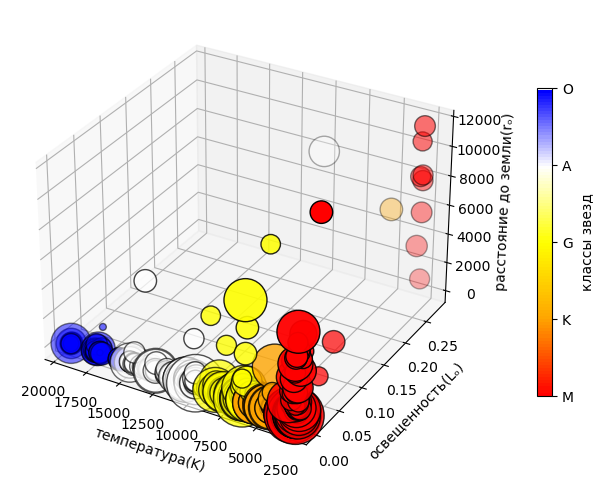

In [179]:
fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot(111, projection='3d')
k = 3000

yP = Luminosity_DecisionTree[0][:k]
xP = Temperature_DecisionTree[0][:k]
zP = distance_RandomForest[0][:k]
size = dfm['Radius(R/Ro)'][:k] * 2000

colors = ['red','orange','yellow','white', 'blue']
n_bins = 100
cmap_name = 'starClasses'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N= n_bins)

everycolor = []
for j in range(len(Temperature_DecisionTree[0])):
    if Temperature_DecisionTree[0][j] <= 4500 :
        everycolor.append(("#ff0000"))
    if Temperature_DecisionTree[0][j] >= 4501 and Temperature_DecisionTree[0][j] <= 6000:
        everycolor.append(("#ffa500"))
    if Temperature_DecisionTree[0][j] >= 6001 and Temperature_DecisionTree[0][j] <= 10000:
        everycolor.append(("#ffff00"))
    if Temperature_DecisionTree[0][j] >= 10001 and Temperature_DecisionTree[0][j] <= 15000:
        everycolor.append(("#ffffff"))
    if Temperature_DecisionTree[0][j] >= 15001:
        everycolor.append(("#0000ff"))

ax2.scatter(xP,yP,zP,sizes = size, c = everycolor[:k], marker = 'o',edgecolor = 'black', s = 100)

ax2.set_xlabel("температура(K)")
ax2.set_ylabel("освещенность(Lₒ)")
ax2.set_zlabel("расстояние до земли(rₒ)")
plt.gca().invert_xaxis()


Z = [i for i in range(160)]
sm = ScalarMappable(cmap= cm, norm=Normalize(vmin=np.min(Z), vmax=np.max(Z)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, pad=0.1, shrink = 0.5)

cbar.set_ticks([0,40,80,120,160])
cbar.set_ticklabels(['M','K','G','A','O'])

cbar.set_label('классы звезд')
plt.show()

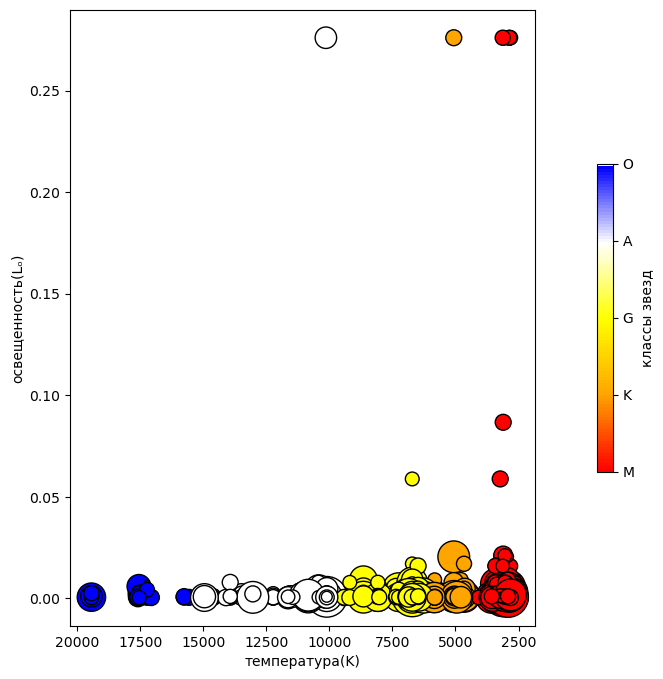

In [182]:
fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot()
k = 3000

yP = Luminosity_DecisionTree[0][:k]
xP = Temperature_DecisionTree[0][:k]
size = dfm['Radius(R/Ro)'][:k] * 1000

colors = ['red','orange','yellow','white', 'blue']
n_bins = 100
cmap_name = 'starClasses'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N= n_bins)

everycolor = []
for j in range(len(Temperature_DecisionTree[0])):
    if Temperature_DecisionTree[0][j] <= 4500 :
        everycolor.append(("#ff0000"))
    if Temperature_DecisionTree[0][j] >= 4501 and Temperature_DecisionTree[0][j] <= 6000:
        everycolor.append(("#ffa500"))
    if Temperature_DecisionTree[0][j] >= 6001 and Temperature_DecisionTree[0][j] <= 10000:
        everycolor.append(("#ffff00"))
    if Temperature_DecisionTree[0][j] >= 10001 and Temperature_DecisionTree[0][j] <= 15000:
        everycolor.append(("#ffffff"))
    if Temperature_DecisionTree[0][j] >= 15001:
        everycolor.append(("#0000ff"))

ax2.scatter(xP,yP,sizes = size, c = everycolor[:k], marker = 'o',edgecolor = 'black', s = 100)

ax2.set_xlabel("температура(K)")
ax2.set_ylabel("освещенность(Lₒ)")
plt.gca().invert_xaxis()


Z = [i for i in range(160)]
sm = ScalarMappable(cmap= cm, norm=Normalize(vmin=np.min(Z), vmax=np.max(Z)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, pad=0.1, shrink = 0.5)

cbar.set_ticks([0,40,80,120,160])
cbar.set_ticklabels(['M','K','G','A','O'])
cbar.set_label('классы звезд')
plt.show()

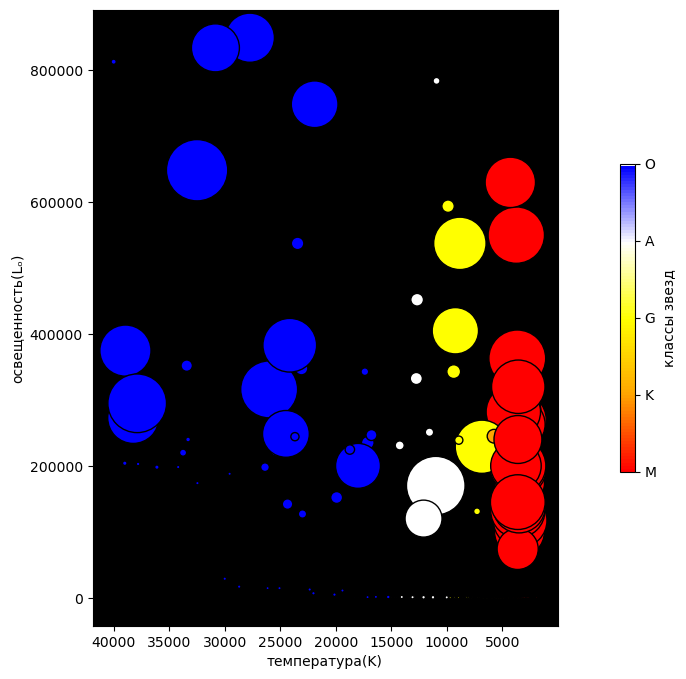

In [181]:
luminosity = test1df['Luminosity(L/Lo)']
temperature = test1df['Temperature (K)']
radius = test1df['Radius(R/Ro)']

fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot()

yP = luminosity
xP = temperature
size = radius

everycolor = []
for j in range(len(temperature)):
    if temperature[j] <= 4500 :
        everycolor.append(("#ff0000"))
    if temperature[j] >= 4501 and temperature[j] <= 6000:
        everycolor.append(("#ffa500"))
    if temperature[j] >= 6001 and temperature[j] <= 10000:
        everycolor.append(("#ffff00"))
    if temperature[j] >= 10001 and temperature[j] <= 15000:
        everycolor.append(("#ffffff"))
    if temperature[j] >= 15001:
        everycolor.append(("#0000ff"))

colors = ['red','orange','yellow','white', 'blue']
n_bins = 100
cmap_name = 'starClasses'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N= n_bins)

ax2.scatter(xP,yP,sizes = size, c = everycolor, marker = 'o',edgecolor = 'black', s = 100)

ax2.set_xlabel("температура(K)")
ax2.set_ylabel("освещенность(Lₒ)")
plt.gca().invert_xaxis()


Z = [i for i in range(160)]
sm = ScalarMappable(cmap= cm, norm=Normalize(vmin=np.min(Z), vmax=np.max(Z)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, pad=0.1, shrink = 0.5)
ax2.set_facecolor(color="black")
cbar.set_ticks([0,40,80,120,160])
cbar.set_ticklabels(['M','K','G','A','O'])

cbar.set_label('классы звезд')
plt.show()